<a href="https://colab.research.google.com/github/mneunhoe/ds3_ml/blob/main/02_ds3_ml_mlr3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# $\text{DS}^3$: Introduction to Machine Learning
(Marcel Neunhoeffer, LMU Munich)

This is the second workbook for the Data Science Summer School course "Introduction to Machine Learning". 

You can find the slides and the other workbooks for this course at: https://github.com/mneunhoe/ds3_ml


In this workbook we will get to know mlr3 a useful (meta) machine learning package in R.



Before we get started, we install and load some helpful packages to our R environment.

In [22]:
p_needed <- c("viridis", "skimr", "mlr3verse", "data.table", "rchallenge", "ranger", "ggplot2")
packages <- rownames(installed.packages())
p_to_install <- p_needed[!(p_needed %in% packages)]
if (length(p_to_install) > 0) {
  install.packages(p_to_install)
}
sapply(p_needed, require, character.only = TRUE)

Loading required package: ggplot2



viridis      skimr  mlr3verse data.table rchallenge     ranger    ggplot2 
      TRUE       TRUE       TRUE       TRUE       TRUE       TRUE       TRUE

## Introduction to mlr3

This workbook is heavily based on an introduction by the mlr3 team: Binder, et al. (2020, March 11). mlr3gallery: mlr3 Basics - German Credit. Retrieved from https://mlr3gallery.mlr-org.com/posts/2020-03-11-basics-german-credit/

They have lots of great resources on their website. If you want to learn more check it out!

### Machine Learning Use Case: German Credit Data

The dataset is part of the rchallenge package (it is also part of the UCI Machine Learning Repository). The goal is to classify people by their credit risk (good or bad) using 20 personal, demographic and financial features.

In [4]:
data("german", package = "rchallenge")

str(german)


'data.frame':	1000 obs. of  21 variables:
 $ status                 : Factor w/ 4 levels "no checking account",..: 1 1 2 1 1 1 1 1 4 2 ...
 $ duration               : int  18 9 12 12 12 10 8 6 18 24 ...
 $ credit_history         : Factor w/ 5 levels "delay in paying off in the past",..: 5 5 3 5 5 5 5 5 5 3 ...
 $ purpose                : Factor w/ 11 levels "others","car (new)",..: 3 1 10 1 1 1 1 1 4 4 ...
 $ amount                 : int  1049 2799 841 2122 2171 2241 3398 1361 1098 3758 ...
 $ savings                : Factor w/ 5 levels "unknown/no savings account",..: 1 1 2 1 1 1 1 1 1 3 ...
 $ employment_duration    : Factor w/ 5 levels "unemployed","< 1 yr",..: 2 3 4 3 3 2 4 2 1 1 ...
 $ installment_rate       : Ord.factor w/ 4 levels ">= 35"<"25 <= ... < 35"<..: 4 2 2 3 4 1 1 2 4 1 ...
 $ personal_status_sex    : Factor w/ 4 levels "male : divorced/separated",..: 2 3 2 3 3 3 3 3 2 2 ...
 $ other_debtors          : Factor w/ 3 levels "none","co-applicant",..: 1 1 1 1 1 1 1 1 1 1 ...

In [5]:
skimr::skim(german)

── Data Summary ────────────────────────
                           Values
Name                       german
Number of rows             1000  
Number of columns          21    
_______________________          
Column type frequency:           
  factor                   18    
  numeric                  3     
________________________         
Group variables            None  

── Variable type: factor ───────────────────────────────────────────────────────
   skim_variable           n_missing complete_rate ordered n_unique
 1 status                          0             1 FALSE          4
 2 credit_history                  0             1 FALSE          5
 3 purpose                         0             1 FALSE         10
 4 savings                         0             1 FALSE          5
 5 employment_duration             0             1 FALSE          5
 6 installment_rate                0             1 TRUE           4
 7 personal_status_sex             0             1 FALSE     

## Modelling

Considering how we are going to tackle the problem of classifying the credit risk relates closely to what mlr3 entities we will use.

The typical questions that arise when building a machine learning workflow are:

* What is the problem we are trying to solve?
* What are appropriate learning algorithms?
* How do we evaluate “good” performance?

More systematically in mlr3 they can be expressed via five components:

* The Task definition.
* The Learner definition.
* The training.
* The prediction.
* The evaluation via one or multiple Measures.

### Task Definition

First, we are interested in the target which we want to model. Most supervised machine learning problems are regression or classification problems. However, note that other problems include unsupervised learning or time-to-event data (covered in mlr3proba).

Within mlr3, to distinguish between these problems, we define Tasks. If we want to solve a classification problem, we define a classification task – TaskClassif. For a regression problem, we define a regression task – TaskRegr.

In our case it is clearly our objective to model or predict the binary factor variable credit_risk. Thus, we define a TaskClassif:


In [6]:
task = TaskClassif$new("GermanCredit", german, target = "credit_risk")

### Learner Definition

After having decided what should be modeled, we need to decide on how it should be modeled. This means we need to decide which learning algorithms, or Learners are appropriate. Using prior knowledge (e.g. knowing that it is a classification task or assuming that the classes are linearly separable) one ends up with one or more suitable Learners.

Many learners can be obtained via the mlr3learners package. Additionally, many learners are provided via the mlr3extralearners package, from GitHub. These two resources combined account for a large fraction of standard learning algorithms. As mlr3 usually only wraps learners from packages, it is also easy to create a formal Learner by yourself. You may find the section about extending mlr3 in the mlr3book very helpful. If you happen to write your own Learner in mlr3, the mlr3 team would be happy if you share it with the mlr3 community.

All available Learners (i.e. all which you have installed from mlr3, mlr3learners, mlr3extralearners, or self-written ones) are registered in the dictionary mlr_learners:

In [7]:
mlr_learners

<DictionaryLearner> with 51 stored values
Keys: classif.cv_glmnet, classif.debug, classif.featureless,
  classif.glmnet, classif.kknn, classif.lda, classif.log_reg,
  classif.multinom, classif.naive_bayes, classif.nnet, classif.qda,
  classif.ranger, classif.rpart, classif.svm, classif.xgboost,
  clust.agnes, clust.ap, clust.cmeans, clust.cobweb, clust.dbscan,
  clust.diana, clust.em, clust.fanny, clust.featureless, clust.ff,
  clust.kkmeans, clust.kmeans, clust.MBatchKMeans, clust.meanshift,
  clust.pam, clust.SimpleKMeans, clust.xmeans, dens.hist, dens.kde,
  regr.cv_glmnet, regr.featureless, regr.glmnet, regr.kknn, regr.km,
  regr.lm, regr.ranger, regr.rpart, regr.svm, regr.xgboost, surv.coxph,
  surv.cv_glmnet, surv.glmnet, surv.kaplan, surv.ranger, surv.rpart,
  surv.xgboost

For our problem, a suitable learner could be one of the following: Logistic regression, CART, random forest (or many more).

A learner can be initialized with the lrn() function and the name of the learner, e.g., lrn("classif.xxx"). Use ?mlr_learners_xxx to open the help page of a learner named xxx.

For example, a logistic regression can be initialized in the following manner (logistic regression uses R’s glm() function and is provided by the mlr3learners package):

In [9]:
library("mlr3learners")
learner_logreg = lrn("classif.log_reg")
print(learner_logreg)

Loading required package: mlr3



<LearnerClassifLogReg:classif.log_reg>
* Model: -
* Parameters: list()
* Packages: stats
* Predict Type: response
* Feature types: logical, integer, numeric, character, factor, ordered
* Properties: twoclass, weights


### Training 

Training is the procedure, where a model is fitted on the (training) data.

#### LOGISTIC REGRESSION

We start with the example of logistic regression. However, you will immediately see that the procedure generalizes to any learner very easily.

An initialized learner can be trained on data using $train():




In [10]:
learner_logreg$train(task)


Typically, in machine learning, one does not use the full data which is available but a subset, the so-called training data.

To efficiently perform a split of the data one could do the following:



In [11]:
train_set = sample(task$row_ids, 0.8 * task$nrow)
test_set = setdiff(task$row_ids, train_set)


80 percent of the data is used for training. The remaining 20 percent are used for evaluation at a subsequent later point in time. train_set is an integer vector referring to the selected rows of the original dataset:



In [12]:
head(train_set)

[1]  46 711 628 809 798 987

In mlr3 the training with a subset of the data can be declared by the additional argument row_ids = train_set:



In [13]:
learner_logreg$train(task, row_ids = train_set)

The fitted model can be accessed via:

In [14]:
learner_logreg$model


Call:  stats::glm(formula = task$formula(), family = "binomial", data = task$data(), 
    model = FALSE)

Coefficients:
                                              (Intercept)  
                                               -1.4373237  
                                                      age  
                                                0.0137829  
                                                   amount  
                                               -0.0001629  
   credit_historycritical account/other credits elsewhere  
                                                0.1593185  
credit_historyno credits taken/all credits paid back duly  
                                                0.9038110  
   credit_historyexisting credits paid back duly till now  
                                                1.1002593  
    credit_historyall credits at this bank paid back duly  
                                                1.4918728  
                                       

The stored object is a normal glm object and all its S3 methods work as expected:



In [16]:
class(learner_logreg$model)

[1] "glm" "lm"

In [15]:
summary(learner_logreg$model)


Call:
stats::glm(formula = task$formula(), family = "binomial", data = task$data(), 
    model = FALSE)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-3.1431  -0.6098   0.3489   0.6733   2.1762  

Coefficients:
                                                            Estimate Std. Error
(Intercept)                                               -1.437e+00  1.352e+00
age                                                        1.378e-02  1.081e-02
amount                                                    -1.629e-04  5.124e-05
credit_historycritical account/other credits elsewhere     1.593e-01  6.685e-01
credit_historyno credits taken/all credits paid back duly  9.038e-01  5.319e-01
credit_historyexisting credits paid back duly till now     1.100e+00  5.751e-01
credit_historyall credits at this bank paid back duly      1.492e+00  5.348e-01
duration                                                  -2.146e-02  1.105e-02
employment_duration< 1 yr                     

RANDOM FOREST

Just like the logistic regression, we could train a random forest instead. We use the fast implementation from the ranger package. For this, we first need to define the learner and then actually train it.

We now additionally supply the importance argument (importance = "permutation"). Doing so, we override the default and let the learner do feature importance determination based on permutation feature importance:

In [19]:
learner_rf = lrn("classif.ranger", importance = "permutation")
learner_rf$train(task, row_ids = train_set)

We can access the importance values using $importance():

In [20]:
learner_rf$importance()

status                duration                  amount 
           0.0337611659            0.0129361289            0.0101876142 
         credit_history                 savings                     age 
           0.0088914549            0.0081419947            0.0065995196 
       installment_rate                property     personal_status_sex 
           0.0055512215            0.0049246477            0.0036498765 
    employment_duration                 purpose           other_debtors 
           0.0035629186            0.0030489930            0.0026661194 
              telephone                     job       present_residence 
           0.0025043588            0.0021063419            0.0018547672 
other_installment_plans                 housing          number_credits 
           0.0016895502            0.0016513786            0.0012791809 
         foreign_worker           people_liable 
           0.0006603219            0.0004616304

In order to obtain a plot for the importance values, we convert the importance to a data.table and then process it with ggplot2:

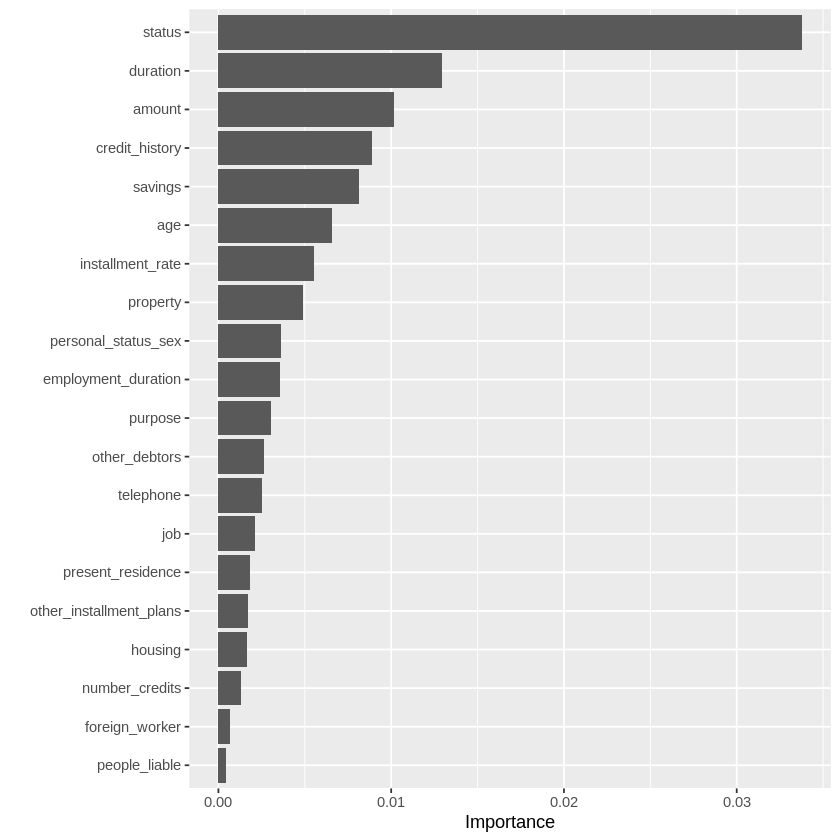

In [23]:
importance = as.data.table(learner_rf$importance(), keep.rownames = TRUE)
colnames(importance) = c("Feature", "Importance")
ggplot(importance, aes(x = reorder(Feature, Importance), y = Importance)) +
  geom_col() + coord_flip() + xlab("")

### Prediction

Let’s see what the models predict.

After training a model, the model can be used for prediction. Usually, prediction is the main purpose of machine learning models.

In our case, the model can be used to classify new credit applicants w.r.t. their associated credit risk (good vs. bad) on the basis of the features. Typically, machine learning models predict numeric values. In the regression case this is very natural. For classification, most models predict scores or probabilities. Based on these values, one can derive class predictions.

PREDICT CLASSES

First, we directly predict classes:



In [24]:
pred_logreg = learner_logreg$predict(task, row_ids = test_set)
pred_rf = learner_rf$predict(task, row_ids = test_set)

The $predict() method returns a Prediction object. It can be converted to a data.table if one wants to use it downstream.

We can also display the prediction results aggregated in a confusion matrix:



In [25]:
pred_logreg$confusion

pred_rf$confusion

        truth
response bad good
    bad   27   16
    good  41  116

        truth
response bad good
    bad   25    6
    good  43  126

PREDICT PROBABILITIES

Most learners may not only predict a class variable (“response”), but also their degree of “belief” / “uncertainty” in a given response. Typically, we achieve this by setting the $predict_type slot of a Learner to "prob". Sometimes this needs to be done before the learner is trained. Alternatively, we can directly create the learner with this option: lrn("classif.log_reg", predict_type = "prob").

In [26]:
learner_logreg$predict_type = "prob"
learner_logreg$predict(task, row_ids = test_set)

<PredictionClassif> for 200 observations:
    row_ids truth response   prob.bad prob.good
          4  good     good 0.35407483 0.6459252
          6  good     good 0.16742516 0.8325748
         12  good     good 0.10238820 0.8976118
---                                            
        984   bad      bad 0.78443411 0.2155659
        985   bad     good 0.03334372 0.9666563
        999   bad     good 0.02165121 0.9783488

Note that sometimes one needs to be cautious when dealing with the probability interpretation of the predictions.

### Performance Evaluation

To measure the performance of a learner on new unseen data, we usually mimic the scenario of unseen data by splitting up the data into training and test set. The training set is used for training the learner, and the test set is only used for predicting and evaluating the performance of the trained learner. Numerous resampling methods (cross-validation, bootstrap) repeat the splitting process in different ways.

Within mlr3, we need to specify the resampling strategy using the rsmp() function:

In [27]:
resampling = rsmp("holdout", ratio = 2/3)
print(resampling)

<ResamplingHoldout> with 1 iterations
* Instantiated: FALSE
* Parameters: ratio=0.6667


Here, we use “holdout”, a simple train-test split (with just one iteration). We use the resample() function to undertake the resampling calculation:

In [28]:
res = resample(task, learner = learner_logreg, resampling = resampling)
res

INFO  [02:53:48.492] [mlr3]  Applying learner 'classif.log_reg' on task 'GermanCredit' (iter 1/1) 


<ResampleResult> of 1 iterations
* Task: GermanCredit
* Learner: classif.log_reg
* Warnings: 0 in 0 iterations
* Errors: 0 in 0 iterations

The default score of the measure is included in the $aggregate() slot:

In [29]:
res$aggregate()

classif.ce 
 0.2372372

The default measure in this scenario is the classification error. Lower is better.

We can easily run different resampling strategies, e.g. repeated holdout ("subsampling"), or cross validation. Most methods perform repeated train/predict cycles on different data subsets and aggregate the result (usually as the mean). Doing this manually would require us to write many loops. mlr3 does the job for us:



In [30]:
resampling = rsmp("subsampling", repeats = 10)
rr = resample(task, learner = learner_logreg, resampling = resampling)
rr$aggregate()


INFO  [02:55:12.888] [mlr3]  Applying learner 'classif.log_reg' on task 'GermanCredit' (iter 1/10) 
INFO  [02:55:12.959] [mlr3]  Applying learner 'classif.log_reg' on task 'GermanCredit' (iter 10/10) 
INFO  [02:55:13.006] [mlr3]  Applying learner 'classif.log_reg' on task 'GermanCredit' (iter 8/10) 
INFO  [02:55:13.041] [mlr3]  Applying learner 'classif.log_reg' on task 'GermanCredit' (iter 4/10) 
INFO  [02:55:13.079] [mlr3]  Applying learner 'classif.log_reg' on task 'GermanCredit' (iter 2/10) 
INFO  [02:55:13.137] [mlr3]  Applying learner 'classif.log_reg' on task 'GermanCredit' (iter 7/10) 
INFO  [02:55:13.173] [mlr3]  Applying learner 'classif.log_reg' on task 'GermanCredit' (iter 6/10) 
INFO  [02:55:13.229] [mlr3]  Applying learner 'classif.log_reg' on task 'GermanCredit' (iter 5/10) 
INFO  [02:55:13.263] [mlr3]  Applying learner 'classif.log_reg' on task 'GermanCredit' (iter 3/10) 
INFO  [02:55:13.295] [mlr3]  Applying learner 'classif.log_reg' on task 'GermanCredit' (iter 9/10) 

classif.ce 
  0.260961

Instead, we could also run cross-validation:

In [31]:
resampling = resampling = rsmp("cv", folds = 10)
rr = resample(task, learner = learner_logreg, resampling = resampling)
rr$aggregate()

INFO  [02:56:04.693] [mlr3]  Applying learner 'classif.log_reg' on task 'GermanCredit' (iter 5/10) 
INFO  [02:56:04.731] [mlr3]  Applying learner 'classif.log_reg' on task 'GermanCredit' (iter 6/10) 
INFO  [02:56:04.768] [mlr3]  Applying learner 'classif.log_reg' on task 'GermanCredit' (iter 10/10) 
INFO  [02:56:04.818] [mlr3]  Applying learner 'classif.log_reg' on task 'GermanCredit' (iter 2/10) 
INFO  [02:56:04.856] [mlr3]  Applying learner 'classif.log_reg' on task 'GermanCredit' (iter 1/10) 
INFO  [02:56:04.895] [mlr3]  Applying learner 'classif.log_reg' on task 'GermanCredit' (iter 8/10) 
INFO  [02:56:04.932] [mlr3]  Applying learner 'classif.log_reg' on task 'GermanCredit' (iter 9/10) 
INFO  [02:56:04.978] [mlr3]  Applying learner 'classif.log_reg' on task 'GermanCredit' (iter 7/10) 
INFO  [02:56:05.013] [mlr3]  Applying learner 'classif.log_reg' on task 'GermanCredit' (iter 3/10) 
INFO  [02:56:05.049] [mlr3]  Applying learner 'classif.log_reg' on task 'GermanCredit' (iter 4/10) 

classif.ce 
      0.25

mlr3 features scores for many more measures. Here, we apply mlr_measures_classif.fpr for the false positive rate, and mlr_measures_classif.fnr for the false negative rate. Multiple measures can be provided as a list of measures (which can directly be constructed via msrs()):

In [32]:
# false positive rate
rr$aggregate(msr("classif.fpr"))

classif.fpr 
  0.1436942

In [33]:
# false positive rate and false negative
measures = msrs(c("classif.fpr", "classif.fnr"))
rr$aggregate(measures)

classif.fpr classif.fnr 
  0.1436942   0.4991722

There are a few more resampling methods, and quite a few more measures (implemented in mlr3measures). They are automatically registered in the respective dictionaries:



In [34]:
mlr_resamplings

<DictionaryResampling> with 8 stored values
Keys: bootstrap, custom, cv, holdout, insample, loo, repeated_cv,
  subsampling

In [35]:
mlr_measures

<DictionaryMeasure> with 82 stored values
Keys: classif.acc, classif.auc, classif.bacc, classif.bbrier,
  classif.ce, classif.costs, classif.dor, classif.fbeta, classif.fdr,
  classif.fn, classif.fnr, classif.fomr, classif.fp, classif.fpr,
  classif.logloss, classif.mbrier, classif.mcc, classif.npv,
  classif.ppv, classif.prauc, classif.precision, classif.recall,
  classif.sensitivity, classif.specificity, classif.tn, classif.tnr,
  classif.tp, classif.tpr, clust.ch, clust.db, clust.dunn,
  clust.silhouette, debug, dens.logloss, oob_error, regr.bias,
  regr.ktau, regr.mae, regr.mape, regr.maxae, regr.medae, regr.medse,
  regr.mse, regr.msle, regr.pbias, regr.rae, regr.rmse, regr.rmsle,
  regr.rrse, regr.rse, regr.rsq, regr.sae, regr.smape, regr.srho,
  regr.sse, selected_features, surv.brier, surv.calib_alpha,
  surv.calib_beta, surv.chambless_auc, surv.cindex, surv.dcalib,
  surv.graf, surv.hung_auc, surv.intlogloss, surv.logloss, surv.mae,
  surv.mse, surv.nagelk_r2, surv.oquigley_r2

To get help on a resampling method, use ?mlr_resamplings_xxx, for a measure do ?mlr_measures_xxx. You can also browse the mlr3 reference online.

Note that some measures, for example AUC, require the prediction of probabilities.



### Performance Comparisons and Benchmarks 

We could compare Learners by evaluating resample() for each of them manually. However, benchmark() automatically performs resampling evaluations for multiple learners and tasks. benchmark_grid() creates fully crossed designs: Multiple Learners for multiple Tasks are compared w.r.t. multiple Resamplings.

In [36]:
learners = lrns(c("classif.log_reg", "classif.ranger"), predict_type = "prob")
bm_design = benchmark_grid(
  tasks = task,
  learners = learners,
  resamplings = rsmp("cv", folds = 10)
)
bmr = benchmark(bm_design)

INFO  [02:59:36.983] [mlr3]  Running benchmark with 20 resampling iterations 
INFO  [02:59:36.993] [mlr3]  Applying learner 'classif.log_reg' on task 'GermanCredit' (iter 10/10) 
INFO  [02:59:37.036] [mlr3]  Applying learner 'classif.log_reg' on task 'GermanCredit' (iter 9/10) 
INFO  [02:59:37.081] [mlr3]  Applying learner 'classif.ranger' on task 'GermanCredit' (iter 2/10) 
INFO  [02:59:37.446] [mlr3]  Applying learner 'classif.ranger' on task 'GermanCredit' (iter 9/10) 
INFO  [02:59:37.803] [mlr3]  Applying learner 'classif.ranger' on task 'GermanCredit' (iter 6/10) 
INFO  [02:59:38.149] [mlr3]  Applying learner 'classif.log_reg' on task 'GermanCredit' (iter 7/10) 
INFO  [02:59:38.191] [mlr3]  Applying learner 'classif.ranger' on task 'GermanCredit' (iter 7/10) 
INFO  [02:59:38.555] [mlr3]  Applying learner 'classif.ranger' on task 'GermanCredit' (iter 1/10) 
INFO  [02:59:38.902] [mlr3]  Applying learner 'classif.ranger' on task 'GermanCredit' (iter 4/10) 
INFO  [02:59:39.256] [mlr3]

Careful, large benchmarks may take a long time! This one should take less than a minute, however. In general, we want to use parallelization to speed things up on multi-core machines. For parallelization, mlr3 relies on the future package:

In [ ]:
#future::plan("multiprocess") # uncomment for parallelization

In the benchmark we can compare different measures. Here, we look at the misclassification rate and the AUC:

In [37]:
measures = msrs(c("classif.ce", "classif.auc"))
performances = bmr$aggregate(measures)
performances[, c("learner_id", "classif.ce", "classif.auc")]

learner_id,classif.ce,classif.auc
<chr>,<dbl>,<dbl>
classif.log_reg,0.254,0.7706921
classif.ranger,0.237,0.7944455


We see that the two models perform very similarly.

## Hyperparameter Tuning

The previously shown techniques build the backbone of a mlr3-featured machine learning workflow. However, in most cases one would never proceed in the way we did. While many R packages have carefully selected default settings, they will not perform optimally in any scenario. Typically, we can select the values of such hyperparameters. The (hyper)parameters of a Learner can be accessed and set via its ParamSet $param_set:

In [38]:
learner_rf$param_set

<ParamSet>
                              id    class lower upper nlevels        default
 1:                        alpha ParamDbl  -Inf   Inf     Inf            0.5
 2:       always.split.variables ParamUty    NA    NA     Inf <NoDefault[3]>
 3:                class.weights ParamDbl  -Inf   Inf     Inf               
 4:                      holdout ParamLgl    NA    NA       2          FALSE
 5:                   importance ParamFct    NA    NA       4 <NoDefault[3]>
 6:                   keep.inbag ParamLgl    NA    NA       2          FALSE
 7:                    max.depth ParamInt  -Inf   Inf     Inf               
 8:                min.node.size ParamInt     1   Inf     Inf              1
 9:                     min.prop ParamDbl  -Inf   Inf     Inf            0.1
10:                      minprop ParamDbl  -Inf   Inf     Inf            0.1
11:                         mtry ParamInt     1   Inf     Inf <NoDefault[3]>
12:            num.random.splits ParamInt     1   Inf     Inf    

In [39]:
learner_rf$param_set$values = list(verbose = FALSE)

We can choose parameters for our learners in two distinct manners. If we have prior knowledge on how the learner should be (hyper-)parameterized, the way to go would be manually entering the parameters in the parameter set. In most cases, however, we would want to tune the learner so that it can search “good” model configurations itself. For now, we only want to compare a few models.

To get an idea on which parameters can be manipulated, we can investigate the parameters of the original package version or look into the parameter set of the learner:

In [40]:
as.data.table(learner_rf$param_set)[, .(id, class, lower, upper)]

id,class,lower,upper
<chr>,<chr>,<dbl>,<dbl>
num.trees,ParamInt,1,Inf
mtry,ParamInt,1,Inf
importance,ParamFct,NA,NA
write.forest,ParamLgl,NA,NA
min.node.size,ParamInt,1,Inf
replace,ParamLgl,NA,NA
sample.fraction,ParamDbl,0,1
class.weights,ParamDbl,-Inf,Inf
splitrule,ParamFct,NA,NA


For the random forest two meaningful parameters which steer model complexity are num.trees and mtry. num.trees defaults to 500 and mtry to floor(sqrt(ncol(data) - 1)), in our case 4.

In the following we aim to train three different learners:

The default random forest.
A random forest with low num.trees and low mtry.
A random forest with high num.trees and high mtry.
We will benchmark their performance on the German credit dataset. For this we construct the three learners and set the parameters accordingly:

In [42]:
rf_med = lrn("classif.ranger", id = "med", predict_type = "prob")

rf_low = lrn("classif.ranger", id = "low", predict_type = "prob",
  num.trees = 5, mtry = 2)

rf_high = lrn("classif.ranger", id = "high", predict_type = "prob",
  num.trees = 1000, mtry = 11)

Once the learners are defined, we can benchmark them:



In [43]:
learners = list(rf_low, rf_med, rf_high)
bm_design = benchmark_grid(
  tasks = task,
  learners = learners,
  resamplings = rsmp("cv", folds = 10)
)
bmr = benchmark(bm_design)
print(bmr)

INFO  [03:05:17.285] [mlr3]  Running benchmark with 30 resampling iterations 
INFO  [03:05:17.295] [mlr3]  Applying learner 'low' on task 'GermanCredit' (iter 3/10) 
INFO  [03:05:17.322] [mlr3]  Applying learner 'low' on task 'GermanCredit' (iter 5/10) 
INFO  [03:05:17.349] [mlr3]  Applying learner 'med' on task 'GermanCredit' (iter 10/10) 
INFO  [03:05:17.701] [mlr3]  Applying learner 'med' on task 'GermanCredit' (iter 2/10) 
INFO  [03:05:18.067] [mlr3]  Applying learner 'med' on task 'GermanCredit' (iter 6/10) 
INFO  [03:05:18.429] [mlr3]  Applying learner 'high' on task 'GermanCredit' (iter 2/10) 
INFO  [03:05:19.469] [mlr3]  Applying learner 'low' on task 'GermanCredit' (iter 10/10) 
INFO  [03:05:19.496] [mlr3]  Applying learner 'high' on task 'GermanCredit' (iter 1/10) 
INFO  [03:05:20.514] [mlr3]  Applying learner 'high' on task 'GermanCredit' (iter 7/10) 
INFO  [03:05:21.522] [mlr3]  Applying learner 'med' on task 'GermanCredit' (iter 9/10) 
INFO  [03:05:21.870] [mlr3]  Applying

We compare misclassification rate and AUC again:



In [44]:
measures = msrs(c("classif.ce", "classif.auc"))
performances = bmr$aggregate(measures)
performances[, .(learner_id, classif.ce, classif.auc)]

learner_id,classif.ce,classif.auc
<chr>,<dbl>,<dbl>
low,0.274,0.7162329
med,0.237,0.7952268
high,0.233,0.7945119


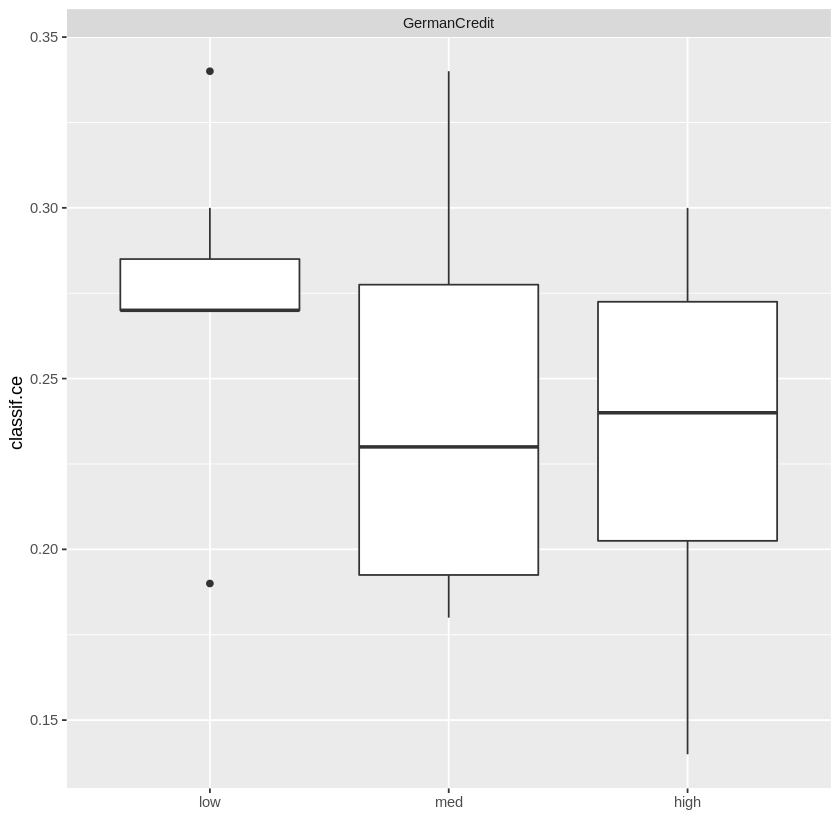

In [45]:
autoplot(bmr)

The “low” settings seem to underfit a bit, the “high” setting is comparable to the default setting “med”.